# Orthonormal Matrices

If you understand orthonormal sets of vectors and how we can generate one with the Gram-Schmdt process then the transition to orthonormal matrices should be pretty smooth. That is because we can take the vectors from a set of vectors and slide them into the columns of a matrix pretty easily.

$\{\vec{v}_1, \vec{v}_2, ..., \vec{v}_n\} \to \begin{pmatrix}
  \vdots & \vdots & \vdots & \vdots \\
  \vec{v}_1 & \vec{v}_2 & \cdots & \vec{v}_n \\
  \vdots  & \vdots  & \vdots & \vdots 
  \end{pmatrix}$
  
This is useful since computers and matrices work well together, that is why the following function performing the Gram-Schmidt process accepts a matrix and produces and orthonormal matrix ($Q$). The orthonormal matrix still holds the same relationship between the columns of the matrix as the vectors in an orthonormal set of vectors. 

1. The inner product of all the columns with one another will be ZERO
2. Each column in matrix is normalized so that $\|\vec{v} \| _2 = 1$

In [62]:
import numpy as np

def gram_schmidt(A):
    m, n  = A.shape
    Q = np.zeros((m, n))
    Q[:, 0] = A[:, 0] / np.linalg.norm(A[:, 0], 2)
    for i in range(1, n):
        Q[:, i] = A[:, i]
        for j in range(0, i):
            inner = np.dot(Q[:, j].T, Q[:, i])
            Q[:, i] = Q[:, i] - np.dot(inner, Q[:, j])
        Q[:, i] = Q[:, i] / np.linalg.norm(Q[:, i], 2)
    return Q

In [63]:
A = np.array(np.random.randint (0, 10, (3, 3)), dtype=np.float64)
print("A: ")
print(A)
print("Q: ")
Q = gram_schmidt(A)
print(Q)

A: 
[[6. 1. 4.]
 [1. 2. 5.]
 [9. 8. 5.]]
Q: 
[[ 0.55234477 -0.79844222  0.23959399]
 [ 0.09205746  0.34408007  0.93441657]
 [ 0.82851716  0.49406369 -0.26355339]]


We can check numerically that we $Q^T = Q^{-1}$ by ensuring $Q^T Q = I$. This knowledge that $Q^T Q = Q Q^T = I$ is the important bit that I want to emphasize because it will allow us to do a LOT going forward with using linear algebra in computational applications

In [64]:
I = np.dot(Q.T, Q)
print("Check: ")
print(I)
print(np.round(I))

Check: 
[[ 1.00000000e+00 -5.55111512e-17  0.00000000e+00]
 [-5.55111512e-17  1.00000000e+00 -2.77555756e-17]
 [ 0.00000000e+00 -2.77555756e-17  1.00000000e+00]]
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]


## Benchmarking Linear Systems

Without looking too far into the benefits that come from orthonormal matrices, we must first look at how they effect a solving a linear system.

$ A \vec{x} = \vec{b}$

Strictly from an analytical standpoint, what would be the fastest way to solve such a linear system that has no numerical values involved? I'll even make this easier. How might we solve for x in a conventional equation $ax=b$?
Well we would divide both sides of the equation by $a$ to get that $1x=b/a$. I purposely leave $1$ in this equations to more explicitly point out that $1= a a^{-1}$. Nothing much changes when we introduce more dimensions with matrices and vectors. 

$ A^{-1}A\vec{x} = A^{-1}\vec{b}$ and $ A^{-1}A = I
so ...
$ I\vec{x} = A^{-1}\vec{b}$

$\vec{x} = A^{-1}\vec{b}$

Now back in the numerical and computational world, obtaining $A^{-1}$ is not super straight forward. Nor is solving a linear system (that is why we have gaussian elimination and matrix decompositions we must perform).
However, if we can recognize that the matrix in a linear system is orthonormal i.e. $ Q \vec{x} = \vec{b}$, then we have a very quick and easy exploit we can use to solve the linear system quickly and easily.

Suppose...

$ Q \vec{x} = \vec{b}$ and $Q^T Q = Q Q^T = I$ so $Q^T = Q^{-1}$

so

$ I\vec{x} = Q^{-1}\vec{b} = Q^{T}\vec{b}$
$ \vec{x} = Q^{T}\vec{b}$

That is the real key here. Transposing a matrix and performing matrix multiplications are much simpler and quicker than doing matrix decompositions and gaussian elimination. 
The power orthonormal matrices give us with regard to the linear system is the power to numerically/computationally solve such a linear system with the same ease by which we can solve any old linear system analyticaly. That is simply by multiplying both sides of out system by the inverse of out matrix.

But of course do not just take my word for it. The following code should prove that to you.

In [66]:
from time import perf_counter_ns

b = np.array(np.random.randint (0, 10, (3, 1)), dtype=np.float64)

start_A = perf_counter_ns()
x1 = np.linalg.solve(A, b)
end_A = perf_counter_ns()
print(f"Random Matrix Time: {(end_A - start_A)/1000} ms")

start_Q = perf_counter_ns()
x2 = np.linalg.solve(A, b)
end_Q = perf_counter_ns()
print(f"Orthonormal Matrix Time: {(end_Q - start_Q)/1000} ms")

Random Matrix Time: 106.307 ms
Orthonormal Matrix Time: 79.925 ms


You can run the above code a few times to see that solving the system with the orthonormal matrix $Q$ is much faster.
But it would be better if we could do some benchmarking. So below we'll generate $A_{100 \times 100}$ and $Q_{100 \times 100}$ all the way up to $1000 \times 1000$ dimension $A$ and $Q$ matrices to better see that the linear system with the orthonormal matrix ($ Q \vec{x} = \vec{b}$) gets solved faster.

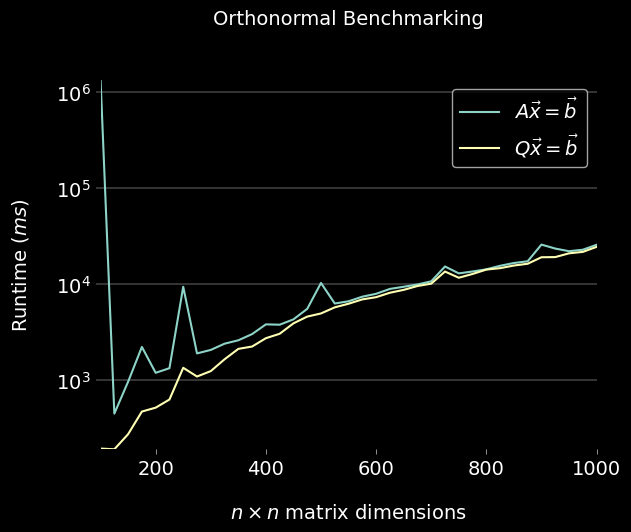

In [86]:
import matplotlib.pyplot as plt

def makematrices(n):
    A = np.array(np.random.randint(0, 256, (n, n)), dtype=np.float64)
    b = np.array(np.random.randint(0, 256, (n, 1)), dtype=np.float64)
    Q = gram_schmidt(A)
    return A, Q, b

benchstats = {"n":[],
              "A Times": [],
              "Q Times": []
             }
for n in np.arange(100, 1025, 25):
    benchstats["n"].append(n)
    A, Q, b = makematrices(n)
    # Begin benchmarking Ax=b
    start_A = perf_counter_ns()
    x1 = np.linalg.solve(A, b)
    end_A = perf_counter_ns()
    atime = (end_A - start_A)/ 1000
    benchstats["A Times"].append(atime)
    # Begin benchmarking Qx = b
    start_Q = perf_counter_ns()
    x2 = np.linalg.solve(Q, b)
    end_Q = perf_counter_ns()
    qtime = (end_Q - start_Q)/ 1000
    benchstats["Q Times"].append(qtime)
    
fig, a = plt.subplots()
a.plot(benchstats["n"], benchstats["A Times"], label=r"$ A \vec{x} = \vec{b}$")
a.plot(benchstats["n"], benchstats["Q Times"], label=r"$ Q \vec{x} = \vec{b}$")
a.set_yscale("log")
a.set_title("Orthonormal Benchmarking")
a.set_ylabel(r"Runtime ($ms$)")
a.set_xlabel(r"$n \times n$ matrix dimensions")
plt.legend()
plt.style.use("dark_background")
plt.show()

So excluding the fact that my VM is acting up at the beginning, we can clearly see that solving a linear system that contains an orthonormal matrix $Q$ is not only faster, but that is as we scale the size of the matrices it remains faster even if only marginally once we reach the higher dimensions.